**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Joe Zhang <br/>
Student Number: 300245795

Name: Christian Paravalos<br/>
Student Number: 300231900

## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [66]:
# Load Packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import warnings

warnings.filterwarnings('default')

In [8]:
url_train = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_train.csv"
url_test = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_test.csv"
url_validation = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_valid.csv"

train_data = pd.read_csv(url_train, header = None)
test_data = pd.read_csv(url_test, header = None)
valid_data = pd.read_csv(url_validation, header = None)

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

In [10]:
# We shuffle the rows of the data
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)
valid_data = valid_data.sample(frac = 1)

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

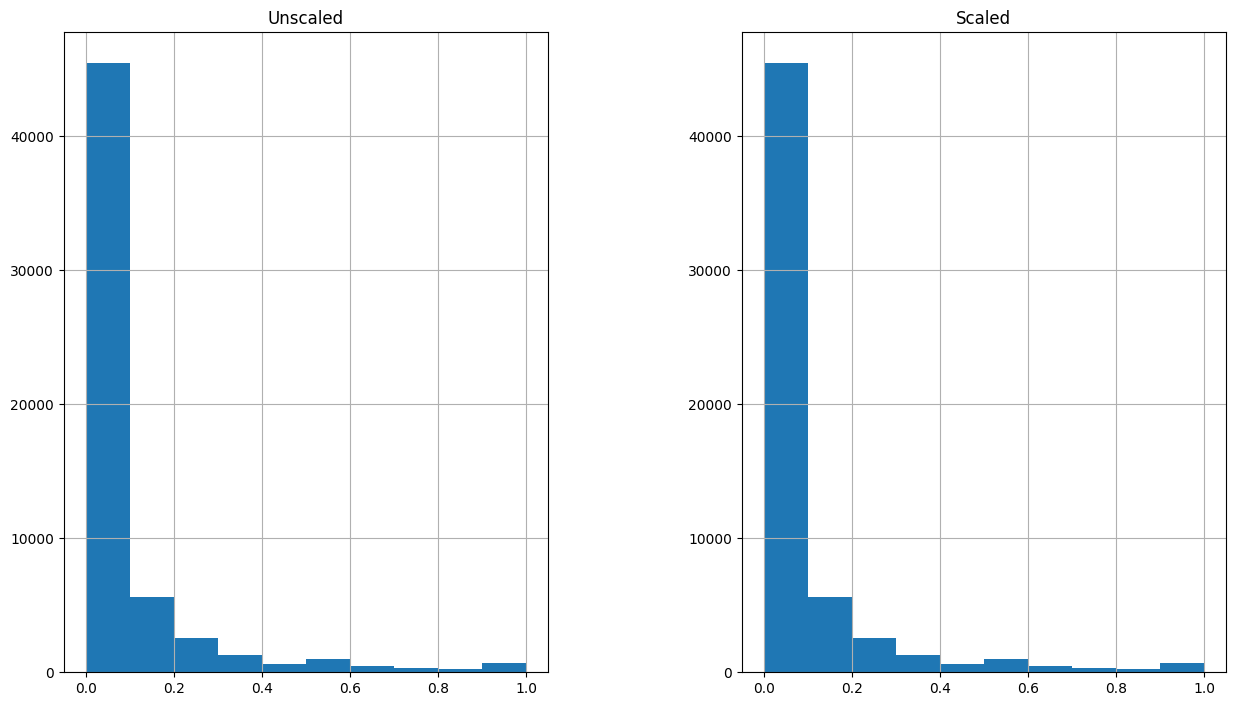

In [33]:
# We create a dataframe that stores the scaled dataset
scaler = MinMaxScaler()
scaler = scaler.fit(train_data)
scaled_data = scaler.transform(train_data)

scaled_data = pd.DataFrame(scaled_data)

# We display charts showing the distributions of the first feature comparing scaled and non-scaled
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

train_data.hist(column = 1, ax = axes[0])
axes[0].set_title("Unscaled")

scaled_data.hist(column = 1, ax = axes[1])
axes[1].set_title("Scaled")

plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)

plt.show()

We scaled the features of the data using MinMaxScaler. Above are the histograms of the first column of the dataframe, before and after scaling. We have seen that there are no differences between the graphs. This is because that the maximum is 1 and the minimum is 0 for the column, so normalization has no effect on the data. Therefore, we believe that scaling is not necessary with this dataset.

4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [69]:
# Code cell
X_train = train_data.drop(columns = [0])
y_train = train_data[0]

X_test = test_data.drop(columns = [0])
y_test = test_data[0]

X_valid = valid_data.drop(columns = [0])
y_valid = valid_data[0]

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Basline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [70]:
# Dummy Model
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [71]:
# Baseline Model
# Note: I'm training all 3 models for now. We're only keeping one of them.
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)


LogisticRegression()

In [72]:
# Neural Network
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy")

model.fit(X_train, y_train, validation_data = (X_valid, y_valid))

1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step - loss: 0.8812 - val_loss: 0.7712


6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [77]:
# We now run cross-validation to evaluate the baseline model

# We evaluate all 3 models for now. We decide on one later

# Create the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average = 'micro'),
    'recall': make_scorer(recall_score, average = 'micro'),
    'f1_score': make_scorer(f1_score, average = 'micro')
}

cv_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

clf_scores_dt = cross_validate(tree_clf, X_train, y_train, cv = cv_folds, scoring = scoring)
clf_scores_knn = cross_validate(knn_clf, X_train, y_train, cv = cv_folds, scoring = scoring)
clf_scores_logit = cross_validate(logit_clf, X_train, y_train, cv = cv_folds, scoring = scoring)

# Print the results in tabular form for decision tree
print("Statistics per fold (Decision Tree):")
print(f"{'Fold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")

# Display the statistics for EACH fold
for i in range(len(clf_scores_dt['test_accuracy'])):
    print(f"{i+1:<10} {clf_scores_dt['test_accuracy'][i]:<10.3f} {clf_scores_dt['test_precision'][i]:<10.3f} "
          f"{clf_scores_dt['test_recall'][i]:<10.3f} {clf_scores_dt['test_f1_score'][i]:<10.3f}")

# Display the mean statistics across ALL folds
print("\nMean statistics over all folds (Decision Tree):")
print(f"Mean Accuracy: {clf_scores_dt['test_accuracy'].mean():.3f}")
print(f"Mean Precision: {clf_scores_dt['test_precision'].mean():.3f}")
print(f"Mean Recall: {clf_scores_dt['test_recall'].mean():.3f}")
print(f"Mean F1-Score: {clf_scores_dt['test_f1_score'].mean():.3f}")

# Print the results in tabular form for K Nearest Neighbors
print("\nStatistics per fold (kNN):")
print(f"{'Fold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")

# Display the statistics for EACH folds
for i in range(len(clf_scores_knn['test_accuracy'])):
    print(f"{i+1:<10} {clf_scores_knn['test_accuracy'][i]:<10.3f} {clf_scores_knn['test_precision'][i]:<10.3f} "
          f"{clf_scores_knn['test_recall'][i]:<10.3f} {clf_scores_knn['test_f1_score'][i]:<10.3f}")

# Display the mean statistics across ALL folds
print("\nMean statistics over all folds (kNN):")
print(f"Mean Accuracy: {clf_scores_knn['test_accuracy'].mean():.3f}")
print(f"Mean Precision: {clf_scores_knn['test_precision'].mean():.3f}")
print(f"Mean Recall: {clf_scores_knn['test_recall'].mean():.3f}")
print(f"Mean F1-Score: {clf_scores_knn['test_f1_score'].mean():.3f}")

# Print the results in tabular form for Logistic Regression
print("\nStatistics per fold (Logistic Regression):")
print(f"{'Fold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")

# Display the statistics for EACH folds
for i in range(len(clf_scores_logit['test_accuracy'])):
    print(f"{i+1:<10} {clf_scores_logit['test_accuracy'][i]:<10.3f} {clf_scores_logit['test_precision'][i]:<10.3f} "
          f"{clf_scores_logit['test_recall'][i]:<10.3f} {clf_scores_logit['test_f1_score'][i]:<10.3f}")

# Display the mean statistics across ALL folds
print("\nMean statistics over all folds (Logistic Regression):")
print(f"Mean Accuracy: {clf_scores_logit['test_accuracy'].mean():.3f}")
print(f"Mean Precision: {clf_scores_logit['test_precision'].mean():.3f}")
print(f"Mean Recall: {clf_scores_logit['test_recall'].mean():.3f}")
print(f"Mean F1-Score: {clf_scores_logit['test_f1_score'].mean():.3f}")



Statistics per fold (Decision Tree):
Fold       Accuracy   Precision  Recall     F1-score  
1          0.497      0.497      0.497      0.497     
2          0.501      0.501      0.501      0.501     
3          0.498      0.498      0.498      0.498     
4          0.504      0.504      0.504      0.504     
5          0.496      0.496      0.496      0.496     

Mean statistics over all folds (Decision Tree):
Mean Accuracy: 0.499
Mean Precision: 0.499
Mean Recall: 0.499
Mean F1-Score: 0.499

Statistics per fold (kNN):
Fold       Accuracy   Precision  Recall     F1-score  
1          0.469      0.469      0.469      0.469     
2          0.469      0.469      0.469      0.469     
3          0.463      0.463      0.463      0.463     
4          0.465      0.465      0.465      0.465     
5          0.461      0.461      0.461      0.461     

Mean statistics over all folds (kNN):
Mean Accuracy: 0.465
Mean Precision: 0.465
Mean Recall: 0.465
Mean F1-Score: 0.465

Statistics per fold 

- **Training neural networks can be time-consuming**. Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.

In [78]:
# We now evaluate the neural network model using the validation set
model.evaluate(X_valid, y_valid)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - loss: 0.7678


0.7712223529815674


- Assess the models using metrics such as precision, recall, and F1-score.

### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

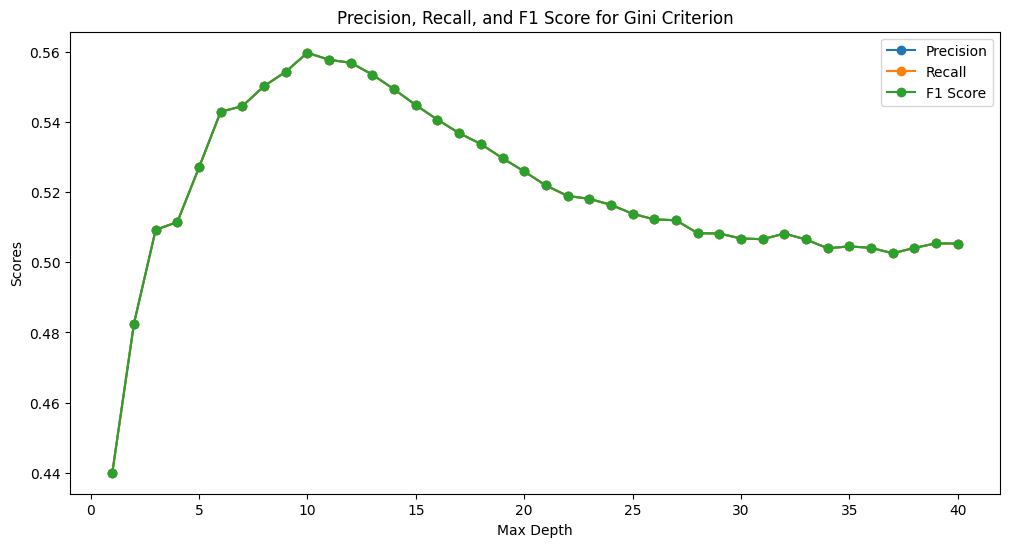

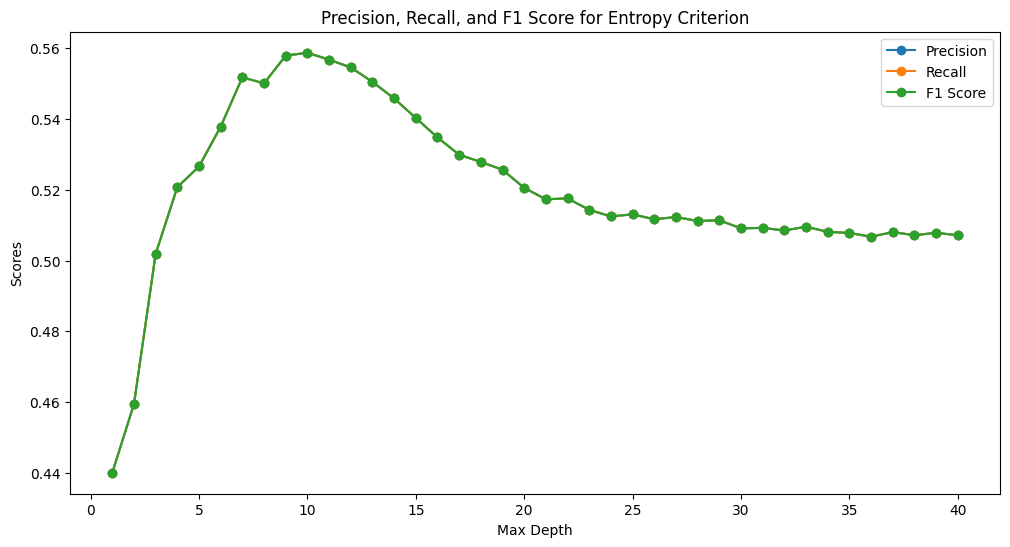

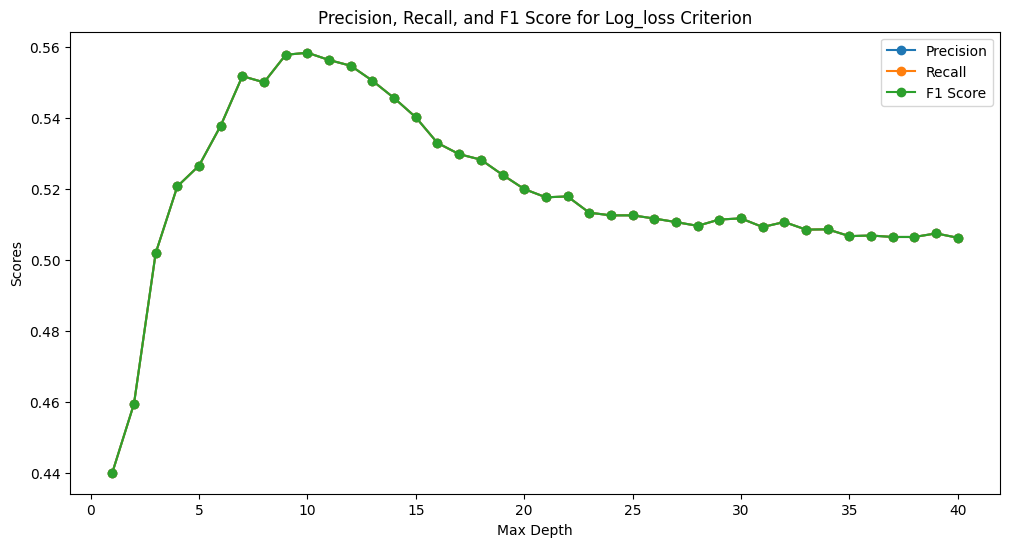

In [79]:
# We now find the best parameters for baseline models
scoring = {
    'precision': make_scorer(precision_score, average = 'micro'),
    'recall': make_scorer(recall_score, average = 'micro'),
    'f1_score': make_scorer(f1_score, average = 'micro')
}

criteria = ['gini', 'entropy', 'log_loss']
max_depth_range = range(1, 41)

param_grid_dt = {
    'criterion': criteria,
    'max_depth': max_depth_range
}

grid_search_dt = GridSearchCV(tree_clf, param_grid_dt, cv = 5, scoring = scoring, refit = 'f1_score')
grid_search_dt.fit(X_train, y_train)

# Initialize a dictionary to store scores for each criterion and max_depth combination
results = {criterion: {'precision': [], 'recall': [], 'f1_score': []} for criterion in criteria}

# Loop over each criterion to extract metrics for each value of max_depth
for criterion in criteria:
    for depth in max_depth_range:
        # Find index where the current criterion and max_depth are used
        index = [
            i for i, params in enumerate(grid_search_dt.cv_results_['params'])
            if params['criterion'] == criterion and params['max_depth'] == depth][0]

        # Append the corresponding scores to the results dictionary
        results[criterion]['precision'].append(grid_search_dt.cv_results_['mean_test_precision'][index])
        results[criterion]['recall'].append(grid_search_dt.cv_results_['mean_test_recall'][index])
        results[criterion]['f1_score'].append(grid_search_dt.cv_results_['mean_test_f1_score'][index])

# Plotting each criterion separately with smoothed lines
for criterion in criteria:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot smoothed lines for precision, recall, and f1-scores for each max_depth value
    ax.plot(max_depth_range, results[criterion]['precision'], label='Precision', marker='o')
    ax.plot(max_depth_range, results[criterion]['recall'], label='Recall', marker='o')
    ax.plot(max_depth_range, results[criterion]['f1_score'], label='F1 Score', marker='o')

    # Add labels, title, and legend
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Scores')
    ax.set_title(f'Precision, Recall, and F1 Score for {criterion.capitalize()} Criterion')
    ax.legend()

    # Show plot
    plt.show()

8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - accuracy: 0.4388 - loss: 1.0119 - val_accuracy: 0.5007 - val_loss: 0.9541
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.4858 - loss: 0.9385 - val_accuracy: 0.5029 - val_loss: 0.9515
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - accuracy: 0.4867 - loss: 0.9360 - val_accuracy: 0.5029 - val_loss: 0.9515
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - accuracy: 0.4877 - loss: 0.9355 - val_accuracy: 0.5024 - val_loss: 0.9516
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - accuracy: 0.4870 - loss: 0.9352 - val_accuracy: 0.5026 - val_loss: 0.9517
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.4875 - loss: 0.9350 - val_accuracy: 0.5026 - val_loss: 0.9517
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.4875 - loss: 0.9348 - val_accuracy: 0.5021 - val_loss: 0.9517
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - accuracy: 0.4877 -

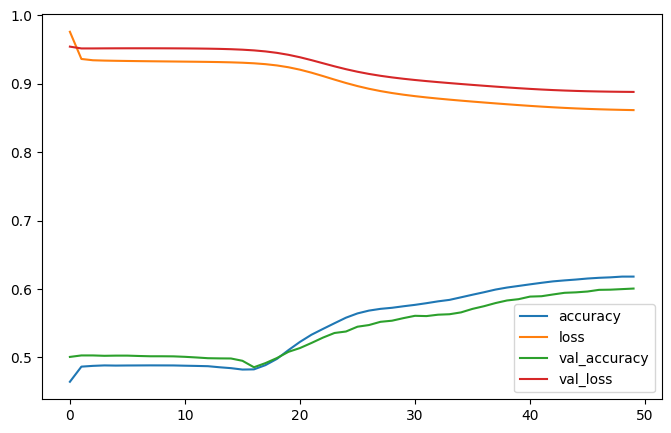

In [80]:
# We now evaluate neural networks with one hidden layer and varying number of nodes
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

 - **Varying the number of layers**.

    - Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

    - How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

     - Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

In [ ]:
# Code cell

- **Activation function**.

  - Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

In [ ]:
# Code cell

- **Regularization** in neural networks is a technique used to prevent overfitting.

  - One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

In [ ]:
# Code cell

 - Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

In [ ]:
# Code cell

 - Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

In [ ]:
# Code cell

- Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

In [ ]:
# Code cell

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [ ]:
# Code cell

# Resources